This notebook takes a descriptive look at clearance rates for MPD cases with and without NIBIN information.

In [1]:
import sys
sys.path.append('..')
import os 
import pandas as pd
import re #For regular expressions
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

lab_blue = '#2b4888'
lab_pink = '#de4057'
lab_grey = '#595959'

# Where our data lives
DATA_DIR = os.path.join('..', 'data')

## Data Munging

In [2]:
#Read in data from MPD

## ------- Crimes data ------- ##
dcr_crimes = pd.read_csv(os.path.join(DATA_DIR, 'DCRCrime_161101_190430.csv'),
                         dtype={'CCN': str}, 
                         parse_dates = [['Event Start Date', 'Event Start Time']])

dcr_crimes.rename(columns={'Event Start Date_Event Start Time': 'event_time'}, 
                  inplace = True)

# Condense so that we only have 1 date, and convert to a datetime format. 
dcr_crimes['event_time'] = pd.to_datetime(dcr_crimes.event_time\
                                          .apply(lambda x: re.findall(r'(.* [AP]M) ', x)[0]))


dcr_crimes = dcr_crimes.drop(['DCR Report Hour',
                              'DCR Report Date&Time',
                              'Start Hour', 
                              'Weekday', 
                              'Offense Location District',
                              'Offense Location GEOX',
                              'Offense Location GEOY'], axis=1)


## ------- Arrests Data ------- ##
arrests = pd.read_csv(os.path.join(DATA_DIR, 'all_arrests_2016_2019.csv'), 
                      encoding = 'cp1252', dtype={'CCN': str}, 
                      parse_dates = [['Arrest Date', 'Arrest Time']])

arrests.rename(columns={'Arrest Date_Arrest Time': 'event_time',
                        'Arrest Booking Date_Arrest Booking Time': 'booking_time',
                        'Arrest Investigation Severity': 'severity',
                        'Charge Description': 'charge_description',
                        'Arrest Investigation Category/Description': 'category',
                        'Arrest Number#': 'arrest_id',
                        'Charge Number': 'charge_id'}, 
               inplace = True)

# drop rows that do not have a location
arrests = arrests[~(arrests['Arrest Location GeoX'].isnull()|arrests['Arrest Location GeoY'].isnull())]

arrests = arrests.drop(['Defendant Last Name',
                        'Defendant First Name', 
                        'Defendant Middle Name', 
                        'Defendant DOB',
                        'Defendant Address1', 
                        'Defendant Address2', 
                        'Defendant City',
                        'Defendant State',
                        'Defendant District',
                        'Defendant Race', 
                        'Defendant Ethnicity',
                        'Arresting Officer First Name', 
                        'Arresting Officer Last Name'], axis=1)


## ------- NIBIN data ------- ##

# Read the sheets from the Excel file sent to us by the Department of Forensic Sciences (DFS)
nibin = pd.read_excel(os.path.join(DATA_DIR,'NIBIN_Entry_thelab_2017-2019.xlsx'), 
                      sheet_name=None)

# Assign each sheet its own dataframe
nibin_entries = nibin['NIBIN_Entry'] 
nibin_hits = nibin['nibin_hits']

In [3]:
# Clean NIBIN data

# DC CCNs should start with the last two digits of the year eg 19_
# followed by 6 numbers.

# We want to standardize the CCNs, and grab the last 8 digits of the CCNs
for df in [nibin_entries, nibin_hits]:
    #Remove hyphens
    df['CCN'] = df['CCN'].str.replace('-', '')
    #Get the last 8 digits
    df['CCN'] = df['CCN'].str[-8:]

    
# The following two chunks drops rows that do not have a CCN and ensures that the 
# entries and hits we get follow the rule of thumb that CCN starts with the year
nibin_entries = nibin_entries[~nibin_entries.CCN.isna()]
nibin_entries = nibin_entries[(nibin_entries.CCN.str.startswith('19'))|\
                              (nibin_entries.CCN.str.startswith('18'))|\
                              (nibin_entries.CCN.str.startswith('17'))|\
                              (nibin_entries.CCN.str.startswith('16'))]    

nibin_hits = nibin_hits[~nibin_hits.CCN.isna()]
nibin_hits = nibin_hits[(nibin_hits.CCN.str.startswith('19'))|\
                        (nibin_hits.CCN.str.startswith('18'))|\
                        (nibin_hits.CCN.str.startswith('17'))|\
                        (nibin_hits.CCN.str.startswith('16'))]


print(nibin_entries.shape)
print(nibin_hits.shape)

(23445, 20)
(694, 4)


In [4]:
## Filter our datasets to be within the period of interest
date_start = '2017-11-01'
date_end = '2019-05-01'

dcr_crimes = dcr_crimes[(dcr_crimes.event_time >= date_start) & (dcr_crimes.event_time < date_end)]
arrests = arrests[(arrests.event_time >= date_start) & (arrests.event_time < date_end)]

print('Checking date range:')
print('Date range for crimes: ', dcr_crimes.event_time.min(), 'to', dcr_crimes.event_time.max())
print('Date range for arrests: ', arrests.event_time.min(), 'to', arrests.event_time.max())
print('\n')


## Filter our dataset to be contained within the location of interest (7D). 
# Create a list of PSAs in 7D, and convert them to strings 
psa_list = (np.arange(701, 709, 1))
psa_list = [str(i) for i in psa_list]

print('Filtering for PSAs contained within 7D:')
print('Rows and columns before filtering:', dcr_crimes.shape)
dcr_crimes_7D = dcr_crimes[dcr_crimes['Offense Location PSA'].isin(psa_list)]
print('Rows and columns after filtering:', dcr_crimes_7D.shape)

Checking date range:
Date range for crimes:  2017-11-01 00:00:42 to 2019-04-30 22:30:24
Date range for arrests:  2017-11-01 00:00:29 to 2019-04-30 23:43:30


Filtering for PSAs contained within 7D:
Rows and columns before filtering: (48928, 15)
Rows and columns after filtering: (3739, 15)


## Create the baseline using violent crime incidents (using DCR Crimes dataset)

In [5]:
## Filter for violent crime
# These are the words that are associated with violent offenses
violent_offenses = ["Homicide", "Assault with a Dangerous Weapon", "Robbery", "Sex Abuse"]
violent_offenses = [x.lower() for x in violent_offenses]

# For DC as a whole:
# Filter for violent crimes, then filter for weapon == 'GUN'
violent_crimes_DC = dcr_crimes[dcr_crimes['Offense Category'].str.lower().isin(violent_offenses)].copy()
violent_gun_crimes_DC = violent_crimes_DC[violent_crimes_DC['DCR Weapon']=='GUN'].copy()
#There's one crime that's an exact duplicate, but 2 reports filed
violent_gun_crimes_DC.drop_duplicates(subset = 'CCN', inplace = True) 
print('Rows and columns for DC:', violent_gun_crimes_DC.shape)

# For just 7D
violent_crimes_7D = dcr_crimes_7D[dcr_crimes_7D['Offense Category'].str.lower().isin(violent_offenses)].copy()
violent_crimes_7D = violent_crimes_7D[violent_crimes_7D['DCR Weapon']=='GUN']
violent_crimes_7D.drop_duplicates(subset = 'CCN', inplace = True)
print('Rows and columns for 7D:', violent_crimes_7D.shape)      

Rows and columns for DC: (2328, 15)
Rows and columns for 7D: (524, 15)


## Join the arrests dataset to the baseline data

In [6]:
# First, get the top charge (what the defendant was actually charged with)
print('Rows and columns in our arrests dataset:', arrests.shape)

def get_top_charge(df):
    #use 'severity' column to get the top charge
    return df.sort_values(by=['arrest_id', 'severity'], ascending=[True, False]).drop_duplicates('arrest_id')

arrests = get_top_charge(arrests) 
print('Rows and columns after filtering for the top charge:', arrests.shape)

Rows and columns in our arrests dataset: (111029, 28)
Rows and columns after filtering for the top charge: (70387, 28)


In [7]:
# Merge arrests dataset to the cases dataset for 7D
cases = violent_crimes_7D.merge(arrests, how = 'left', on = 'CCN', indicator=True)

# Drop duplicate CCNs. This is because I only care if there's AT LEAST one arrest. 
cases.drop_duplicates(subset = 'CCN', inplace = True)

#If the CCN appeared in both, that means a person was arrested and the case was cleared
cases['arrested'] = cases._merge == 'both'
cases.drop('_merge', axis = 1, inplace=True)

print('Rows and columns for the cases we are looking at:',cases.shape)

Rows and columns for the cases we are looking at: (524, 43)


In [8]:
print('How many cases have been cleared?\n')
print(cases.arrested.value_counts())
print()
print(cases.arrested.value_counts(normalize = True))

How many cases have been cleared?

False    403
True     121
Name: arrested, dtype: int64

False    0.769084
True     0.230916
Name: arrested, dtype: float64


# Merge with NIBIN information

## NIBIN Entries

NIBIN entries: firearms and cartridge casings that have been entered into NIBIN.

In [9]:
# Drop duplicate CCNs. We only care about cases that have had AT LEAST one nibin entry
entries = nibin_entries.drop_duplicates(subset = 'CCN', keep = 'first')

# Inner join with cases data so that we're only looking at NIBIN-entry info
cases_entry = cases.merge(entries[['CCN']], how = 'left', on = 'CCN', indicator = True)


# Cases that had no NIBIN information will only appear in the left table 
no_nibin_info = cases_entry[cases_entry._merge == 'left_only']

# Cases that had a NIBIN entry will appear in both tables
cases_entry = cases_entry[cases_entry._merge == 'both']

In [10]:
print('Number of cases with arrests (True) with no NIBIN entries')
print(no_nibin_info.arrested.value_counts())
print()

print('Number of cases with arrests (True) with *at least* 1 NIBIN entry\n')
print(cases_entry.arrested.value_counts())
print()
print(cases_entry.arrested.value_counts(normalize = True))

Number of cases with arrests (True) with no NIBIN entries
False    217
True      57
Name: arrested, dtype: int64

Number of cases with arrests (True) with *at least* 1 NIBIN entry

False    186
True      64
Name: arrested, dtype: int64

False    0.744
True     0.256
Name: arrested, dtype: float64


## NIBIN Hits

In [11]:
# Drop duplicate entries and merge with case data
hits = nibin_hits.drop_duplicates(subset = 'CCN', keep = 'first')
cases_nibin_hits = cases_entry.merge(nibin_hits, how = 'inner', on = 'CCN')
print('Number of cases that had at least one NIBIN hit', cases_nibin_hits.shape)
print()

print('Cases with at least one arrest (True) that had at least one NIBIN hit:')
print(cases_nibin_hits.arrested.value_counts())
print()
print(cases_nibin_hits.arrested.value_counts(normalize = True))

Number of cases that had at least one NIBIN hit (81, 47)

Cases with at least one arrest (True) that had at least one NIBIN hit:
False    58
True     23
Name: arrested, dtype: int64

False    0.716049
True     0.283951
Name: arrested, dtype: float64


# Plots

This section generates the plots that go into the final report. We examine cases with and without NIBIN information, because our initial analysis shows that the more information we get, i.e. having ballistics evidence entered into NIBIN and having a case with at least one NIBIN hit, the higher the clearance rate. However, we hypothesize that crimes involving ballistics evidence (e.g. homicides) are substantially different from crimes without ballistics evidence (e.g. robberies) in that there are more resources devoted to those types of crimes, so we examine both to see if that is truly the case. 

In [12]:
def removeHomicides(df):
    ''' 
    This takes in a dataframe and returns a dataframe with the 
    rows where the offense category includes 'Homicide' are removed. 
    '''
    removed = df[df['Offense Category'] != 'Homicide']
    return removed
    
cases_no_hom = removeHomicides(cases) # All cases, including those with and without NIBIN info
no_nibin_no_hom = removeHomicides(no_nibin_info) # Cases w/o NIBIN info
entry_no_hom = removeHomicides(cases_entry) # Cases w at least 1 NIBIN entry
hits_no_hom = removeHomicides(cases_nibin_hits) # Cases w at least 1 NIBIN hit

In [13]:
# Set up a dataframe with the clearance rates broken out by all cases, 
#  cases w/o NIBIN info, cases with NIBIN entries, cases with NIBIN hits

# list of measures 
offenses = ['All Offenses', 'Homicides Excluded'] * 4
metric = ['All Violent Offenses', 'No Ballistics Evidence', 'Any Ballistics Evidence', 'NIBIN Hit']*2
offenses.sort()

# list of dfs we need information on 
dfs = [cases, no_nibin_info, cases_entry, cases_nibin_hits,
       cases_no_hom, no_nibin_no_hom, entry_no_hom, hits_no_hom]

# get the sums and the total number of cases for each df
sums_list = []
total_cases_list = []

for df in dfs:
    sums_list.append(sum(df.arrested))
    total_cases_list.append(len(df))

# Turn into a dataframe    
summary = pd.DataFrame({'Homicide' : offenses, 
                        'Metric' : metric, 
                        'Cleared Cases' : sums_list, 
                        'Total Cases' : total_cases_list})

summary['Clearance Rate %'] = summary['Cleared Cases']/summary['Total Cases']*100

summary

,Homicide,Metric,Cleared Cases,Total Cases,Clearance Rate %
0,All Offenses,All Violent Offenses,121,524,23.091603
1,All Offenses,No Ballistics Evidence,57,274,20.802920
2,All Offenses,Any Ballistics Evidence,64,250,25.600000
3,All Offenses,NIBIN Hit,23,81,28.395062
4,Homicides Excluded,All Violent Offenses,103,467,22.055675
5,Homicides Excluded,No Ballistics Evidence,55,267,20.599251
6,Homicides Excluded,Any Ballistics Evidence,48,200,24.000000
7,Homicides Excluded,NIBIN Hit,11,60,18.333333


In [14]:
def showDataLabels(df, varname):
    ''' 
    Function for creating data labels
    '''
    # Get current axis on current figure
    ax = plt.gca()
    
    n = list((df[varname]).astype(int)) #Raw value
    listerator = 0 #my iterator for the list

    for p in ax.patches: 
        height = p.get_height()
        width = p.get_x() + p.get_width()/2.
        height = np.where(np.isnan(height), 0, height)
        ax.text(x = width, 
                y = height, 
                s = '%.1f' % float(height) + '%\n' + 'N=' + str(n[listerator]),
                fontsize=11, 
                color='black', 
                ha='center', 
                va='bottom')
        if listerator < len(n)-1:
            listerator += 1

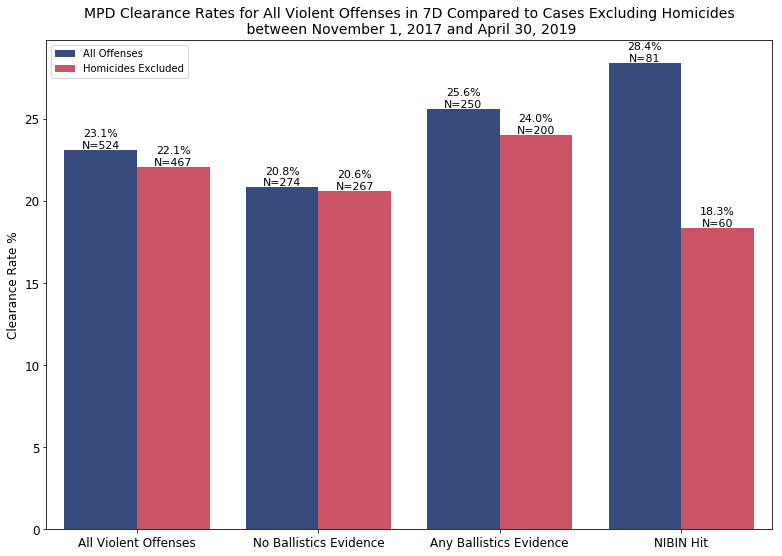

In [15]:
# Side-by-side bar plot of clearance rates for cases involving homicides + cases without homicide

plt.figure(figsize = (13,9))

sns.barplot(x = 'Metric', 
            y = 'Clearance Rate %', 
            hue = 'Homicide', 
            data = summary, 
            palette=[lab_blue, lab_pink])

plt.xlabel('')
plt.ylabel('Clearance Rate %', fontsize = 12)
plt.title('MPD Clearance Rates for All Violent Offenses in 7D Compared to Cases Excluding Homicides' + 
          '\n between November 1, 2017 and April 30, 2019', fontsize = 14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().legend().set_title('')

showDataLabels(df=summary, varname='Total Cases')

In [16]:
def generateCrosstabs(df):
    '''
    Function to generate crosstabs specifically for USAO data
    
    '''
    
    xtab = pd.crosstab(df['Offense Category'], df.arrested, 
                       margins=True, margins_name= 'Total')\
                      .reset_index()\
                      .sort_values(by = 'Total', ascending = False)[1:]
    xtab['Clearance Rate'] = round(xtab[True]/xtab.Total*100,2)
    
    return xtab

In [17]:
no_nibin = generateCrosstabs(no_nibin_info) 
no_nibin["Type of Info"] = 'No NIBIN Info'

entries = generateCrosstabs(cases_entry)
entries["Type of Info"] = 'Ballistics Evidence'

hits = generateCrosstabs(cases_nibin_hits)
hits.loc[-1] = ['Sex Abuse', 0,0,0,0]
hits["Type of Info"] = 'NIBIN Hits'

all_cases = no_nibin.append([entries, hits]).reset_index(drop = True)
all_cases.sort_values(by = 'Offense Category', inplace = True)
all_cases['Type of Info'] = pd.Categorical(all_cases['Type of Info'],
                                           ['No NIBIN Info', 'Ballistics Evidence', 'NIBIN Hits'])
all_cases.sort_values(by = 'Type of Info', inplace = True)
all_cases

arrested,Offense Category,False,True,Total,Clearance Rate,Type of Info
1,Assault with a Dangerous Weapon,60,23,83,27.71,No NIBIN Info
2,Homicide,5,2,7,28.57,No NIBIN Info
0,Robbery,151,31,182,17.03,No NIBIN Info
3,Sex Abuse,1,1,2,50.00,No NIBIN Info
4,Assault with a Dangerous Weapon,144,39,183,21.31,Ballistics Evidence
5,Homicide,34,16,50,32.00,Ballistics Evidence
6,Robbery,8,8,16,50.00,Ballistics Evidence
7,Sex Abuse,0,1,1,100.00,Ballistics Evidence
8,Assault with a Dangerous Weapon,49,9,58,15.52,NIBIN Hits
9,Homicide,9,12,21,57.14,NIBIN Hits


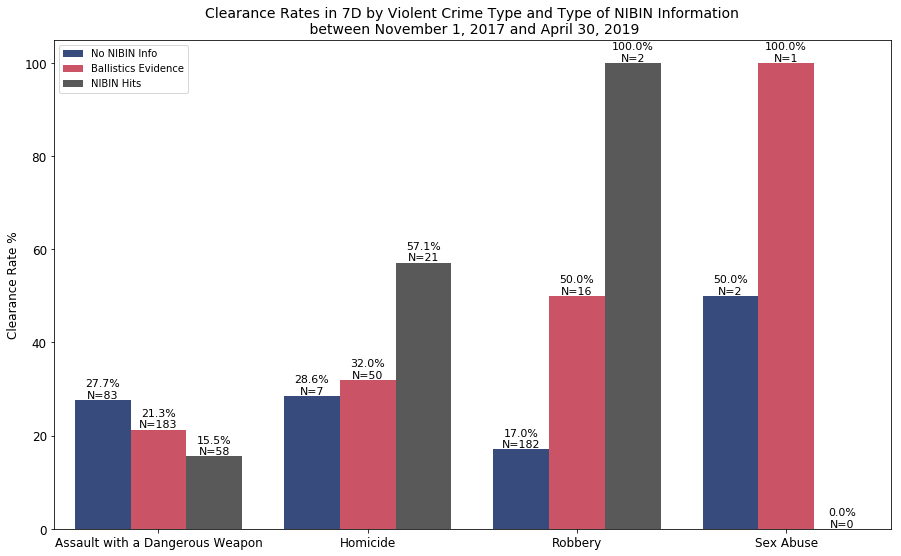

In [18]:
# Barplot broken out by type of offense and the level of NIBIN information available

plt.figure(figsize = (15,9))
sns.barplot(x='Offense Category', 
            y='Clearance Rate', 
            hue='Type of Info', 
            data=all_cases, 
            palette=[lab_blue, lab_pink, lab_grey])

plt.xlabel('')
plt.ylabel('Clearance Rate %', fontsize = 12)
plt.title('Clearance Rates in 7D by Violent Crime Type and Type of NIBIN Information' + 
          '\n between November 1, 2017 and April 30, 2019', fontsize = 14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().legend().set_title('')

showDataLabels(df=all_cases, varname='Total')